In [1]:
import numpy as np
import pandas as pd
import scipy
import spacy
import sys
from collections import Counter
from time import time
import torch
from sklearn import model_selection
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# data = pd.read_csv('articles1.csv')

In [4]:


# # Make a DataFrame with articles by our chosen authors
# # Include author names and article titles.

# # Make a list of the 10 chosen author names
# names = data.author.value_counts()[data.author.value_counts()>100][-30:].index.tolist()

# # DataFrame for articles of all chosen authors
# authors_data = pd.DataFrame()
# for name in names:
#     # Select each author's data
#     articles = data[data.author==name][:100][['title','content','author']]
#     # Append it to the DataFrame
#     authors_data = authors_data.append(articles)

# authors_data = authors_data.reset_index().drop('index',1)
    
# authors_data.head()

In [5]:
# # Look for duplicates
# print('Number of articles:',authors_data.shape[0])
# print('Unique articles:',len(np.unique(authors_data.index)))

# # Number of authors
# print('Unique authors:',len(np.unique(authors_data.author)))
# print('')
# print('Articles by author:\n')

# # Articles counts by author
# print(authors_data.author.value_counts())

In [6]:
# #!{sys.executable} -m spacy download en

# t0 = time()

# # Load spacy NLP object
# nlp = spacy.load("en_core_web_sm")
# # A list to store common words by all authors
# common_words = []

# # A dictionary to store the spacy_doc object of each author
# authors_docs = {}

# for name in names:
#     # Corpus is all the text written by that author
#     corpus = ""
#     # Grab all rows of current author, along the 'content' column
#     author_content = authors_data.loc[authors_data.author==name,'content']
    
#     # Merge all articles in to the author's corpus
#     for article in author_content:
#         corpus = corpus + article
#     # Let Spacy parse the author's body of text
#     doc = nlp(corpus)
    
#     # Store the doc in the dictionary
#     authors_docs[name] = doc
        
#     # Filter out punctuation and stop words.
#     lemmas = [token.lemma_ for token in doc
#                 if not token.is_punct and not token.is_stop]
        
#     # Return the most common words of that author's corpus.
#     bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
#     # Add them to the list of words by all authors.
#     for word in bow:
#         common_words.append(word)

# # Eliminate duplicates
# common_words = set(common_words)
    
# print('Total number of common words:',len(common_words))
# print("done in %0.3fs" % (time() - t0))

In [7]:
# # Let's see our 10 authors in the dictionary
# lengths = []
# for k,v in authors_docs.items():
#     print(k,'corpus contains',len(v),' words.')
#     lengths.append(len(v))



In [8]:
# # check for lower case words
# common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
# print('Count of all common_words:',len(common_words))
# print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# # Turn all common_words into lower case
# common_words = [word.lower() for word in common_words]
# print('Count of lowercase common_words (After Conversion):',np.sum([word.islower() for word in common_words]))


# # We must remove these in to avoid conflicts with existing features.
# if 'author' in common_words:
#     common_words.remove('author')
# if 'title' in common_words:
#     common_words.remove('title')
# if 'content' in common_words:
#     common_words.remove('content')

In [9]:
# # Count the number of times a common_word appears in each article
# # (about 3Hrs processing)

# bow_counts = pd.DataFrame()
# for name in names:
#     # Select X articles of that author
#     articles = authors_data.loc[authors_data.author==name,:][:50]
#     bow_counts = bow_counts.append(articles)
# bow_counts = bow_counts.reset_index().drop('index',1)

# # Use common_words as the columns of a temporary DataFrame
# df = pd.DataFrame(columns=common_words)

# # Join BOW features with the author's content
# bow_counts = bow_counts.join(df)

# # Initialize rows with zeroes
# bow_counts = bow_counts.loc[:,~bow_counts.columns.duplicated()].copy()
# bow_counts.loc[:,common_words] = 0

# # Fill the DataFrame with counts of each feature in each article
# t0 = time()
# for i, article in enumerate(bow_counts.content):
#     doc = nlp(article)
#     for token in doc:
#         if token.lemma_.lower() in common_words:
#             bow_counts.loc[i,token.lemma_.lower()] += 1
#     # Print a message every X articles
#     if i % 50 == 0:
#         if time()-t0 < 3600: # if less than an hour in seconds
#             print("Article ",i," done after ",(time()-t0)/60,' minutes.')
#         else:
#             print("Article ",i," done after ",(time()-t0)/60/60,' hours.')

In [10]:
# This saves the long-awaited data into a pickle file for easy recovery
#bow_counts.to_pickle('bow_counts')
# Read it back in with the following
bow_counts = pd.read_pickle('bow_counts')

In [11]:
y = bow_counts['author']
counter = 0
newy = np.zeros(len(y))
last = y[0]
for i in range(len(y)):
    if y[i] != last:
        counter+=1
    newy[i] = counter
    last = y[i]
X = bow_counts.drop(['content','author','title'], 1)
X = X.loc[:,~X.columns.duplicated()].copy()
X = X.to_numpy()
N, M = X.shape
import torch.nn as nn
#X = scipy.stats.zscore(X)
n_hidden_units = 2     # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
#K = 3                   # only five folds to speed up this example
#CV = model_selection.KFold(K, shuffle=True)
model = torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid(), # final tranfer function
                    )
#loss_fn = torch.nn.MSELoss
# class Net(nn.Module):
#     def __init__(self,D_in,H,D_out):
#         super(Net,self).__init__()
#         self.linear1=nn.Linear(D_in,H)
#         self.linear2=nn.Linear(H,D_out)

        
#     def forward(self,x):
#         x=torch.sigmoid(self.linear1(x))  
#         x=self.linear2(x)
#         return x
# model=Net(M,25,30)
class Net(nn.Module):
    def __init__(self,D_in,H,H2,H3,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,H2)
        #self.linear3=nn.Linear(H2,D_out)
        self.linear3=nn.Linear(H2,H3)
        self.linear4=nn.Linear(H3,D_out)
        
    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=F.relu(self.linear3(x))  
        #x=self.linear3(x)
        x=self.linear4(x)
        return x
#model=Net(M,300,150,30)
loss_fn = torch.nn.CrossEntropyLoss()

C:\Users\penna\AppData\Local\Temp\ipykernel_24372\4032825044.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = bow_counts.drop(['content','author','title'], 1)


In [23]:
batch_size=128
k=20
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [13]:
#dataset = np.column_stack((X,newy))
X = X.astype('float32')
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(newy)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len
dataset=Data()

In [14]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    #for images, labels in dataloader:
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output,labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for inputs, labels in dataloader:

        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)
        loss=loss_fn(output,labels.long())
        valid_loss+=loss.item()*inputs.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [24]:
H1 = round(math.sqrt(M * 30))
H2 = round(H1/2)
H3 = round(H2/2)
foldperf={}
num_epochs=10
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = Net(M,H1,H2,H3,30)
    model.to(device)
    learning_rate=0.0004
    #optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,loss_fn,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  


Fold 1
Epoch:1/10 AVG Training Loss:3.351 AVG Test Loss:3.273 AVG Training Acc 9.40 % AVG Test Acc 24.00 %
Epoch:2/10 AVG Training Loss:3.034 AVG Test Loss:2.956 AVG Training Acc 28.14 % AVG Test Acc 24.00 %
Epoch:3/10 AVG Training Loss:2.513 AVG Test Loss:2.444 AVG Training Acc 44.77 % AVG Test Acc 44.00 %
Epoch:4/10 AVG Training Loss:1.891 AVG Test Loss:1.928 AVG Training Acc 72.28 % AVG Test Acc 64.00 %
Epoch:5/10 AVG Training Loss:1.327 AVG Test Loss:1.609 AVG Training Acc 82.25 % AVG Test Acc 65.33 %
Epoch:6/10 AVG Training Loss:0.908 AVG Test Loss:1.435 AVG Training Acc 89.40 % AVG Test Acc 69.33 %
Epoch:7/10 AVG Training Loss:0.622 AVG Test Loss:1.320 AVG Training Acc 93.19 % AVG Test Acc 68.00 %
Epoch:8/10 AVG Training Loss:0.438 AVG Test Loss:1.322 AVG Training Acc 95.93 % AVG Test Acc 64.00 %
Epoch:9/10 AVG Training Loss:0.316 AVG Test Loss:1.278 AVG Training Acc 97.12 % AVG Test Acc 73.33 %
Epoch:10/10 AVG Training Loss:0.244 AVG Test Loss:1.250 AVG Training Acc 97.89 % AVG 

Epoch:3/10 AVG Training Loss:2.593 AVG Test Loss:2.393 AVG Training Acc 52.28 % AVG Test Acc 50.67 %
Epoch:4/10 AVG Training Loss:1.968 AVG Test Loss:1.946 AVG Training Acc 70.11 % AVG Test Acc 64.00 %
Epoch:5/10 AVG Training Loss:1.362 AVG Test Loss:1.588 AVG Training Acc 85.12 % AVG Test Acc 65.33 %
Epoch:6/10 AVG Training Loss:0.928 AVG Test Loss:1.368 AVG Training Acc 88.56 % AVG Test Acc 65.33 %
Epoch:7/10 AVG Training Loss:0.642 AVG Test Loss:1.262 AVG Training Acc 93.61 % AVG Test Acc 66.67 %
Epoch:8/10 AVG Training Loss:0.445 AVG Test Loss:1.193 AVG Training Acc 95.72 % AVG Test Acc 61.33 %
Epoch:9/10 AVG Training Loss:0.317 AVG Test Loss:1.098 AVG Training Acc 97.33 % AVG Test Acc 68.00 %
Epoch:10/10 AVG Training Loss:0.238 AVG Test Loss:1.233 AVG Training Acc 98.74 % AVG Test Acc 64.00 %
Fold 10
Epoch:1/10 AVG Training Loss:3.355 AVG Test Loss:3.284 AVG Training Acc 10.11 % AVG Test Acc 17.33 %
Epoch:2/10 AVG Training Loss:3.063 AVG Test Loss:3.010 AVG Training Acc 28.28 % AV

Epoch:5/10 AVG Training Loss:1.243 AVG Test Loss:1.326 AVG Training Acc 83.23 % AVG Test Acc 62.67 %
Epoch:6/10 AVG Training Loss:0.828 AVG Test Loss:1.259 AVG Training Acc 90.04 % AVG Test Acc 58.67 %
Epoch:7/10 AVG Training Loss:0.565 AVG Test Loss:1.089 AVG Training Acc 93.82 % AVG Test Acc 62.67 %
Epoch:8/10 AVG Training Loss:0.393 AVG Test Loss:1.066 AVG Training Acc 96.70 % AVG Test Acc 64.00 %
Epoch:9/10 AVG Training Loss:0.277 AVG Test Loss:1.197 AVG Training Acc 98.04 % AVG Test Acc 61.33 %
Epoch:10/10 AVG Training Loss:0.198 AVG Test Loss:1.108 AVG Training Acc 98.81 % AVG Test Acc 61.33 %
Fold 18
Epoch:1/10 AVG Training Loss:3.354 AVG Test Loss:3.276 AVG Training Acc 9.54 % AVG Test Acc 21.33 %
Epoch:2/10 AVG Training Loss:3.030 AVG Test Loss:2.938 AVG Training Acc 33.19 % AVG Test Acc 25.33 %
Epoch:3/10 AVG Training Loss:2.464 AVG Test Loss:2.509 AVG Training Acc 44.28 % AVG Test Acc 49.33 %
Epoch:4/10 AVG Training Loss:1.850 AVG Test Loss:2.075 AVG Training Acc 66.60 % AVG

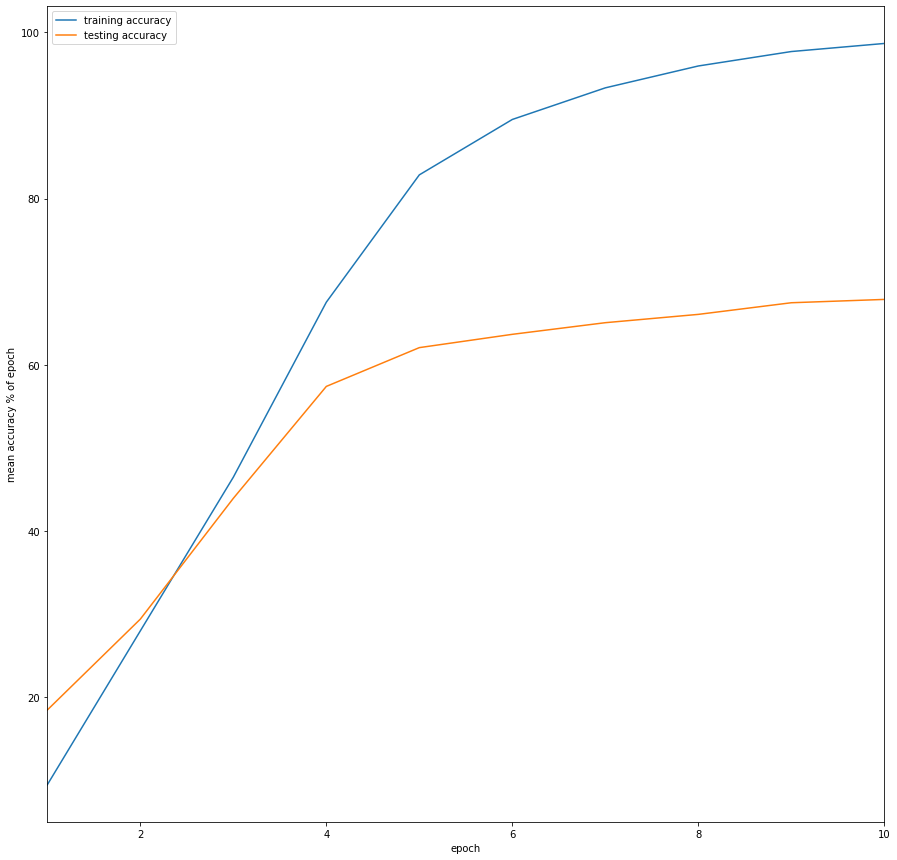

In [25]:
trainacc = []
testacc = []
for j in range(num_epochs):
    testsums = []
    trainsums = []
    for i in range(1,k+1):
        testsums.append(foldperf['fold'+str(i)]['test_acc'][j])
        trainsums.append(foldperf['fold'+str(i)]['train_acc'][j])
    trainacc.append(np.mean(trainsums))
    testacc.append(np.mean(testsums))
plt.figure(figsize=(15,15))
plt.plot(np.arange(1,num_epochs+1), trainacc, label='training accuracy')
plt.plot(np.arange(1,num_epochs+1), testacc, label='testing accuracy')
plt.ylabel('mean accuracy % of epoch')
plt.xlabel('epoch')
plt.xticks([0,2,4,6,8,num_epochs])
plt.legend()
plt.xlim((1,num_epochs))
plt.show()